In [ ]:
!pip install torch
!pip install transformers[torch]
!pip install accelerate
!pip install datasets
!pip install -U accelerate
!pip install -U transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import datasets
from transformers import BertForTokenClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, TensorDataset
import torch
from transformers import AutoModelForTokenClassification, AutoTokenizer, AutoConfig
from transformers import DataCollatorForTokenClassification

In [ ]:
with open('/content/data3.txt','r') as f:
  data3 = f.read()
print(data3)

Seawood B-STORE_NAME
KisanKonnect I-STORE_NAME
Store I-STORE_NAME
Shop O
No.01 O
, O
Shree B-ADDRESS
Ambika I-ADDRESS
Apartments I-ADDRESS
CHS I-ADDRESS
Limit I-ADDRESS
€d I-ADDRESS
Jairan B-ADDRESS
Tukaram I-ADDRESS
Tandel I-ADDRESS
Marg I-ADDRESS
, O
Landmark O
: O
, O
opp B-ADDRESS
. O
Dmart I-ADDRESS
Seawoods I-ADDRESS
, O
Seakoods B-ADDRESS
West I-ADDRESS
, O
Karave B-ADDRESS
Nagar I-ADDRESS
, O
Seawoods I-ADDRESS
, O
Navi B-ADDRESS
Mumbai I-ADDRESS
, O
Maharashtra I-ADDRESS
400706 I-ADDRESS
Phone O
No O
: O
7066050903 B-PHONE
GSTIN O
: O
27AATCKO704C1Z1 B-GSTIN
FSSAI O
: O
21523016000056 B-FSSAI
TAX O
INVOICE O
CUM O
BILL O
OF O
SUPPI O
Bill O
No O
: O
990140 B-BILL_NO
Print O
Time O
: O
2024-05-14 B-DATE_TIME
11:08:22 I-DATE_TIME
Mobile O
No O
: O
9924512721 B-PHONE
Customer O
Name O
: O
sir B-CUSTOMER_NAME
Qty O
Rate O
Total O
Jal B-ITEM
Long I-ITEM
Black I-ITEM
( O
l O
kg O
0.24 B-TOTAL
60.0 B-TOTAL
14.4 B-TOTAL
) O

2 B-ITEM
. O
Dudhi B-ITEM
( O
Bottle I-ITEM
gourd I-ITEM
) O

In [ ]:
final_labels = set()
for i in data3.split('\n'):
  label = i.split(' ')[-1]
  final_labels.add(label)
final_labels.remove('')
print(final_labels)
print(len(final_labels))

{'I-STORE_NAME', 'B-DATE_TIME', 'B-GSTIN', 'I-DATE_TIME', 'B-ITEM', 'I-ITEM', 'B-CUSTOMER_NAME', 'B-TOTAL', 'B-ADDRESS', 'B-FSSAI', 'B-PHONE', 'O', 'B-BILL_NO', 'B-STORE_NAME', 'I-ADDRESS'}
15


In [ ]:
ner_tags = {}
for i,j in enumerate(final_labels):
  ner_tags[j] = i
ner_tags

{'I-STORE_NAME': 0,
 'B-DATE_TIME': 1,
 'B-GSTIN': 2,
 'I-DATE_TIME': 3,
 'B-ITEM': 4,
 'I-ITEM': 5,
 'B-CUSTOMER_NAME': 6,
 'B-TOTAL': 7,
 'B-ADDRESS': 8,
 'B-FSSAI': 9,
 'B-PHONE': 10,
 'O': 11,
 'B-BILL_NO': 12,
 'B-STORE_NAME': 13,
 'I-ADDRESS': 14}

In [ ]:
def ner_dataset_maker(data):
  ner_tagged = []
  labelled =[]
  words = []
  for i in data.split('\n'):

    if i.strip()=='':
      continue
    parts = i.split()

    if len(parts)<2:
      continue



    word = i.split(' ')[0]
    words.append(word)
    label = i.split(' ')[-1]
    labelled.append(label)
    ner_tagged.append(ner_tags[label])
  return words,labelled,ner_tagged


words,labelled,ner_tagged = ner_dataset_maker(data3)

In [ ]:
max(ner_tagged)

14

In [ ]:
new_df = pd.DataFrame({'words':[words],'labels':[labelled],'ner_tags':[ner_tagged]})
new_df['sentence_id'] = new_df.index
new_df

,words,labels,ner_tags,sentence_id
0,"[Seawood, KisanKonnect, Store, Shop, No.01, ,,...","[B-STORE_NAME, I-STORE_NAME, I-STORE_NAME, O, ...","[13, 0, 0, 11, 11, 11, 8, 14, 14, 14, 14, 14, ...",0


In [ ]:
len(new_df['words'][0])

174

In [ ]:
# new_df['words'] = new_df['words'].apply(ast.literal_eval)
# new_df['labels'] = new_df['labels'].apply(ast.literal_eval)
# new_df['ner_tags'] = new_df['ner_tags'].apply(ast.literal_eval)

In [ ]:
raw_data = {}
for idx in new_df['sentence_id'].values:
  raw_data[idx] = {}
  raw_data[idx]['words'] = new_df[new_df['sentence_id']==idx]['words'].values[0]
  raw_data[idx]['labels'] = new_df[new_df['sentence_id']==idx]['labels'].values[0]
  raw_data[idx]['ner_tags'] = new_df[new_df['sentence_id']==idx]['ner_tags'].values[0]
print(raw_data)

{0: {'words': ['Seawood', 'KisanKonnect', 'Store', 'Shop', 'No.01', ',', 'Shree', 'Ambika', 'Apartments', 'CHS', 'Limit', '€d', 'Jairan', 'Tukaram', 'Tandel', 'Marg', ',', 'Landmark', ':', ',', 'opp', '.', 'Dmart', 'Seawoods', ',', 'Seakoods', 'West', ',', 'Karave', 'Nagar', ',', 'Seawoods', ',', 'Navi', 'Mumbai', ',', 'Maharashtra', '400706', 'Phone', 'No', ':', '7066050903', 'GSTIN', ':', '27AATCKO704C1Z1', 'FSSAI', ':', '21523016000056', 'TAX', 'INVOICE', 'CUM', 'BILL', 'OF', 'SUPPI', 'Bill', 'No', ':', '990140', 'Print', 'Time', ':', '2024-05-14', '11:08:22', 'Mobile', 'No', ':', '9924512721', 'Customer', 'Name', ':', 'sir', 'Qty', 'Rate', 'Total', 'Jal', 'Long', 'Black', '(', 'l', 'kg', '0.24', '60.0', '14.4', ')', '2', '.', 'Dudhi', '(', 'Bottle', 'gourd', ')', '(', '1', 'emrg0-', '-', 'Qi', '30', 'Nos', ')', '3', '.', 'Cucumber', 'Green', '(', 'Kakadi-H', 'irvi)(1', 'kg', ')', '0.84', '60.0', '50.16', '4', '.', 'Palak', 'Regular', 'Nos', '(', '1', 'Nos', ')', '5', '.', 'Carrot',

In [ ]:
print(len(raw_data[0]['words']))

174


In [ ]:
print(len(raw_data[0]['labels']))

174


In [ ]:
data_list = []
for idx, data in raw_data.items():
    data_list.append({
        'id': idx,
        'words': data['words'],
        'ner_tags': data['ner_tags'],
        'pos_tags': [],  # Placeholder, as your data doesn't have pos_tags
        'chunk_tags': []  # Placeholder, as your data doesn't have chunk_tags
    })

In [ ]:
data_list

[{'id': 0,
  'words': ['Seawood',
   'KisanKonnect',
   'Store',
   'Shop',
   'No.01',
   ',',
   'Shree',
   'Ambika',
   'Apartments',
   'CHS',
   'Limit',
   '€d',
   'Jairan',
   'Tukaram',
   'Tandel',
   'Marg',
   ',',
   'Landmark',
   ':',
   ',',
   'opp',
   '.',
   'Dmart',
   'Seawoods',
   ',',
   'Seakoods',
   'West',
   ',',
   'Karave',
   'Nagar',
   ',',
   'Seawoods',
   ',',
   'Navi',
   'Mumbai',
   ',',
   'Maharashtra',
   '400706',
   'Phone',
   'No',
   ':',
   '7066050903',
   'GSTIN',
   ':',
   '27AATCKO704C1Z1',
   'FSSAI',
   ':',
   '21523016000056',
   'TAX',
   'INVOICE',
   'CUM',
   'BILL',
   'OF',
   'SUPPI',
   'Bill',
   'No',
   ':',
   '990140',
   'Print',
   'Time',
   ':',
   '2024-05-14',
   '11:08:22',
   'Mobile',
   'No',
   ':',
   '9924512721',
   'Customer',
   'Name',
   ':',
   'sir',
   'Qty',
   'Rate',
   'Total',
   'Jal',
   'Long',
   'Black',
   '(',
   'l',
   'kg',
   '0.24',
   '60.0',
   '14.4',
   ')',
   '2',
   '.

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:

# Convert the list to a Hugging Face Dataset
train_dataset = Dataset.from_dict({k: [d[k] for d in data_list] for k in data_list[0]})

# Create a DatasetDict
raw_data = DatasetDict({"train": train_dataset})
print("DatasetDict: ", raw_data)


DatasetDict:  DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'ner_tags', 'pos_tags', 'chunk_tags'],
        num_rows: 1
    })
})


In [ ]:
# Get labels

label2id = {label: id for id, label in enumerate(final_labels)}
id2label = {id: label for label, id in label2id.items()}
print(label2id)
print(id2label)

{'I-STORE_NAME': 0, 'B-DATE_TIME': 1, 'B-GSTIN': 2, 'I-DATE_TIME': 3, 'B-ITEM': 4, 'I-ITEM': 5, 'B-CUSTOMER_NAME': 6, 'B-TOTAL': 7, 'B-ADDRESS': 8, 'B-FSSAI': 9, 'B-PHONE': 10, 'O': 11, 'B-BILL_NO': 12, 'B-STORE_NAME': 13, 'I-ADDRESS': 14}
{0: 'I-STORE_NAME', 1: 'B-DATE_TIME', 2: 'B-GSTIN', 3: 'I-DATE_TIME', 4: 'B-ITEM', 5: 'I-ITEM', 6: 'B-CUSTOMER_NAME', 7: 'B-TOTAL', 8: 'B-ADDRESS', 9: 'B-FSSAI', 10: 'B-PHONE', 11: 'O', 12: 'B-BILL_NO', 13: 'B-STORE_NAME', 14: 'I-ADDRESS'}


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
inputs = tokenizer(raw_data["train"][0]["words"], is_split_into_words=True)
print(inputs.tokens())   # ['[CLS]', 'I', 'Love', 'you', '[SEP]']
print(inputs.word_ids())  # [None, 0, 1, 2, None]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

['[CLS]', 'Sea', '##wood', 'Ki', '##san', '##K', '##on', '##nect', 'Store', 'Shop', 'No', '.', '01', ',', 'S', '##hr', '##ee', 'Am', '##bi', '##ka', 'Apart', '##ments', 'CH', '##S', 'Lim', '##it', '€', '##d', 'Jai', '##ran', 'Tu', '##kara', '##m', 'Tan', '##del', 'Mar', '##g', ',', 'Landmark', ':', ',', 'op', '##p', '.', 'D', '##mart', 'Sea', '##woods', ',', 'Sea', '##ko', '##ods', 'West', ',', 'Kara', '##ve', 'Nagar', ',', 'Sea', '##woods', ',', 'Na', '##vi', 'Mumbai', ',', 'Maharashtra', '400', '##70', '##6', 'Phone', 'No', ':', '70', '##6', '##60', '##50', '##90', '##3', 'G', '##ST', '##IN', ':', '27', '##AA', '##TC', '##KO', '##70', '##4', '##C', '##1', '##Z', '##1', 'F', '##SS', '##A', '##I', ':', '215', '##23', '##01', '##60', '##00', '##0', '##5', '##6', 'T', '##A', '##X', 'IN', '##VO', '##IC', '##E', 'C', '##UM', 'B', '##IL', '##L', 'OF', 'S', '##UP', '##PI', 'Bill', 'No', ':', '99', '##01', '##40', 'Print', 'Time', ':', '202', '##4', '-', '05', '-', '14', '11', ':', '08', ':',

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["words"], truncation=True, padding=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs


In [ ]:
raw_data

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'ner_tags', 'pos_tags', 'chunk_tags'],
        num_rows: 1
    })
})

In [ ]:
def tokenize_and_align_labels(example,label_all_tokens=True,is_split_into_words=True):
  tokenized_inputs = tokenizer(example['words'],truncation=True,is_split_into_words=True)
  labels = []

  for i,all_ner_tags in enumerate(example['ner_tags']):
    words_ids = tokenized_inputs.word_ids(batch_index=i)
    previous_word_idx = None

    label_ids = []
    for word_idx in words_ids:
      if word_idx is None:
        label_ids.append(-100)
      elif word_idx != previous_word_idx:
        label_ids.append(all_ner_tags[word_idx])
      else:
        label_ids.append(all_ner_tags[word_idx] if label_all_tokens else -100)
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs['labels'] = labels
  return tokenized_inputs



tokenize_and_align_labels(raw_data['train'][0:1])

{'input_ids': [[101, 3017, 2615, 14477, 9995, 2428, 1320, 21032, 10422, 13125, 1302, 119, 5187, 117, 156, 8167, 3051, 7277, 5567, 1968, 10342, 4385, 24890, 1708, 21551, 2875, 836, 1181, 19183, 4047, 17037, 14567, 1306, 13880, 6738, 9751, 1403, 117, 18405, 131, 117, 11769, 1643, 119, 141, 22736, 3017, 24550, 117, 3017, 2718, 16476, 1537, 117, 14069, 2707, 18704, 117, 3017, 24550, 117, 11896, 5086, 8601, 117, 12626, 3434, 20829, 1545, 26385, 1302, 131, 3102, 1545, 16480, 11049, 21500, 1495, 144, 9272, 11607, 131, 1765, 11189, 9481, 16585, 20829, 1527, 1658, 1475, 5301, 1475, 143, 12480, 1592, 2240, 131, 18615, 22737, 24400, 16480, 7629, 1568, 1571, 1545, 157, 1592, 3190, 15969, 21049, 9741, 2036, 140, 25810, 139, 17656, 2162, 11345, 156, 18124, 23203, 2617, 1302, 131, 4850, 24400, 12882, 27833, 2614, 131, 17881, 1527, 118, 4991, 118, 1489, 1429, 131, 4775, 131, 1659, 8410, 1302, 131, 4850, 19598, 24050, 24458, 18202, 25456, 1200, 10208, 131, 6442, 154, 2340, 24442, 8653, 147, 1348, 3261,

In [ ]:
print(raw_data['train'][0])
tokenized = tokenizer(raw_data['train'][0]['words'],is_split_into_words=True)
print(tokenized)
print(tokenized.word_ids())
tokens = tokenizer.convert_ids_to_tokens(tokenized['input_ids'])
print(tokens)
q = tokenize_and_align_labels(raw_data['train'][0:1])
q

{'id': 0, 'words': ['Seawood', 'KisanKonnect', 'Store', 'Shop', 'No.01', ',', 'Shree', 'Ambika', 'Apartments', 'CHS', 'Limit', '€d', 'Jairan', 'Tukaram', 'Tandel', 'Marg', ',', 'Landmark', ':', ',', 'opp', '.', 'Dmart', 'Seawoods', ',', 'Seakoods', 'West', ',', 'Karave', 'Nagar', ',', 'Seawoods', ',', 'Navi', 'Mumbai', ',', 'Maharashtra', '400706', 'Phone', 'No', ':', '7066050903', 'GSTIN', ':', '27AATCKO704C1Z1', 'FSSAI', ':', '21523016000056', 'TAX', 'INVOICE', 'CUM', 'BILL', 'OF', 'SUPPI', 'Bill', 'No', ':', '990140', 'Print', 'Time', ':', '2024-05-14', '11:08:22', 'Mobile', 'No', ':', '9924512721', 'Customer', 'Name', ':', 'sir', 'Qty', 'Rate', 'Total', 'Jal', 'Long', 'Black', '(', 'l', 'kg', '0.24', '60.0', '14.4', ')', '2', '.', 'Dudhi', '(', 'Bottle', 'gourd', ')', '(', '1', 'emrg0-', '-', 'Qi', '30', 'Nos', ')', '3', '.', 'Cucumber', 'Green', '(', 'Kakadi-H', 'irvi)(1', 'kg', ')', '0.84', '60.0', '50.16', '4', '.', 'Palak', 'Regular', 'Nos', '(', '1', 'Nos', ')', '5', '.', 'Car

{'input_ids': [[101, 3017, 2615, 14477, 9995, 2428, 1320, 21032, 10422, 13125, 1302, 119, 5187, 117, 156, 8167, 3051, 7277, 5567, 1968, 10342, 4385, 24890, 1708, 21551, 2875, 836, 1181, 19183, 4047, 17037, 14567, 1306, 13880, 6738, 9751, 1403, 117, 18405, 131, 117, 11769, 1643, 119, 141, 22736, 3017, 24550, 117, 3017, 2718, 16476, 1537, 117, 14069, 2707, 18704, 117, 3017, 24550, 117, 11896, 5086, 8601, 117, 12626, 3434, 20829, 1545, 26385, 1302, 131, 3102, 1545, 16480, 11049, 21500, 1495, 144, 9272, 11607, 131, 1765, 11189, 9481, 16585, 20829, 1527, 1658, 1475, 5301, 1475, 143, 12480, 1592, 2240, 131, 18615, 22737, 24400, 16480, 7629, 1568, 1571, 1545, 157, 1592, 3190, 15969, 21049, 9741, 2036, 140, 25810, 139, 17656, 2162, 11345, 156, 18124, 23203, 2617, 1302, 131, 4850, 24400, 12882, 27833, 2614, 131, 17881, 1527, 118, 4991, 118, 1489, 1429, 131, 4775, 131, 1659, 8410, 1302, 131, 4850, 19598, 24050, 24458, 18202, 25456, 1200, 10208, 131, 6442, 154, 2340, 24442, 8653, 147, 1348, 3261,

In [ ]:
for token, label in zip(tokenizer.convert_ids_to_tokens(q['input_ids'][0]),q['labels'][0]):
  print(f"{token}:{label}")

[CLS]:-100
Sea:13
##wood:13
Ki:0
##san:0
##K:0
##on:0
##nect:0
Store:0
Shop:11
No:11
.:11
01:11
,:11
S:8
##hr:8
##ee:8
Am:14
##bi:14
##ka:14
Apart:14
##ments:14
CH:14
##S:14
Lim:14
##it:14
€:14
##d:14
Jai:8
##ran:8
Tu:14
##kara:14
##m:14
Tan:14
##del:14
Mar:14
##g:14
,:11
Landmark:11
::11
,:11
op:8
##p:8
.:11
D:14
##mart:14
Sea:14
##woods:14
,:11
Sea:8
##ko:8
##ods:8
West:14
,:11
Kara:8
##ve:8
Nagar:14
,:11
Sea:14
##woods:14
,:11
Na:8
##vi:8
Mumbai:14
,:11
Maharashtra:14
400:14
##70:14
##6:14
Phone:11
No:11
::11
70:10
##6:10
##60:10
##50:10
##90:10
##3:10
G:11
##ST:11
##IN:11
::11
27:2
##AA:2
##TC:2
##KO:2
##70:2
##4:2
##C:2
##1:2
##Z:2
##1:2
F:11
##SS:11
##A:11
##I:11
::11
215:9
##23:9
##01:9
##60:9
##00:9
##0:9
##5:9
##6:9
T:11
##A:11
##X:11
IN:11
##VO:11
##IC:11
##E:11
C:11
##UM:11
B:11
##IL:11
##L:11
OF:11
S:11
##UP:11
##PI:11
Bill:11
No:11
::11
99:12
##01:12
##40:12
Print:11
Time:11
::11
202:1
##4:1
-:1
05:1
-:1
14:1
11:3
::3
08:3
::3
22:3
Mobile:11
No:11
::11
99:10
##24:10
##51:1

In [ ]:
tokenized_datasets = raw_data.map(tokenize_and_align_labels,batched=True)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('bert-base-uncased',num_labels=15)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
args = TrainingArguments("test-ner",evaluation_strategy = "epoch",
learning_rate=2e-5,
per_device_train_batch_size=16,
per_device_eval_batch_size=16,
num_train_epochs=3,
weight_decay=0.01)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 813.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=87c7be2ee4dca61054218cc6a101621005fc2fb90e5cb2071d323496e1ca540c
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
metric = datasets.load_metric("seqeval")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
raw_data['train'].features

{'id': Value(dtype='int64', id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=Value(dtype='null', id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=Value(dtype='null', id=None), length=-1, id=None)}

In [ ]:
data['train'][0]['ner_tags']

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [ ]:
# label_list = data['train'].features['ner_tags'].feature.names
# label_list
final_labels

{'B-ADDRESS',
 'B-BILL_NO',
 'B-CUSTOMER_NAME',
 'B-DATE_TIME',
 'B-FSSAI',
 'B-GSTIN',
 'B-ITEM',
 'B-PHONE',
 'B-STORE_NAME',
 'B-TOTAL',
 'I-ADDRESS',
 'I-DATE_TIME',
 'I-ITEM',
 'I-STORE_NAME',
 'O'}

In [ ]:
labels = [label_list[i] for i in data['train'][0]['ner_tags']]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [ ]:
# def compute_metrics(eval_preds):
#     """
#     Function to compute the evaluation metrics for Named Entity Recognition (NER) tasks.
#     The function computes precision, recall, F1 score and accuracy.

#     Parameters:
#     eval_preds (tuple): A tuple containing the predicted logits and the true labels.

#     Returns:
#     A dictionary containing the precision, recall, F1 score and accuracy.
#     """
#     pred_logits, labels = eval_preds

#     pred_logits = np.argmax(pred_logits, axis=2)
#     # the logits and the probabilities are in the same order,
#     # so we don’t need to apply the softmax

#     # We remove all the values where the label is -100
#     predictions = [
#         [final_labels[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100]
#         for prediction, label in zip(pred_logits, labels)
#     ]

#     true_labels = [
#       [final_labels[l] for (eval_preds, l) in zip(prediction, label) if l != -100]
#        for prediction, label in zip(pred_logits, labels)
#    ]
#     results = metric.compute(predictions=predictions, references=true_labels)
#     return {
#    "precision": results["overall_precision"],
#    "recall": results["overall_recall"],
#    "f1": results["overall_f1"],
#   "accuracy": results["overall_accuracy"],
#   }

In [ ]:
# trainer = Trainer(model,args,train_dataset=tokenized_datasets['train'],eval_dataset=tokenized_datasets['train'],data_collator=data_collator,
#    tokenizer=tokenizer,
#    compute_metrics=compute_metrics)

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path="bert-base-cased",
    num_labels=len(final_labels),
    id2label=id2label,
    label2id=label2id,
)

from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-ner",
    # evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=0.001,
    num_train_epochs=3,
    weight_decay=0.01,
    # push_to_hub=True,
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    # train_dataset=tokenized_datasets["train"],
    # eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    # compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()
trainer.save_model("./models_2345")

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


In [ ]:
id2label

{0: 'I-STORE_NAME',
 1: 'B-DATE_TIME',
 2: 'B-GSTIN',
 3: 'I-DATE_TIME',
 4: 'B-ITEM',
 5: 'I-ITEM',
 6: 'B-CUSTOMER_NAME',
 7: 'B-TOTAL',
 8: 'B-ADDRESS',
 9: 'B-FSSAI',
 10: 'B-PHONE',
 11: 'O',
 12: 'B-BILL_NO',
 13: 'B-STORE_NAME',
 14: 'I-ADDRESS'}

#importing the model

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
import shutil
shutil.copy('/content/mydrive/MyDrive/models_2345.zip','/content/')

'/content/models_2345.zip'

In [ ]:
shutil.unpack_archive('/content/models_2345.zip','/content/model/','zip')

#inference

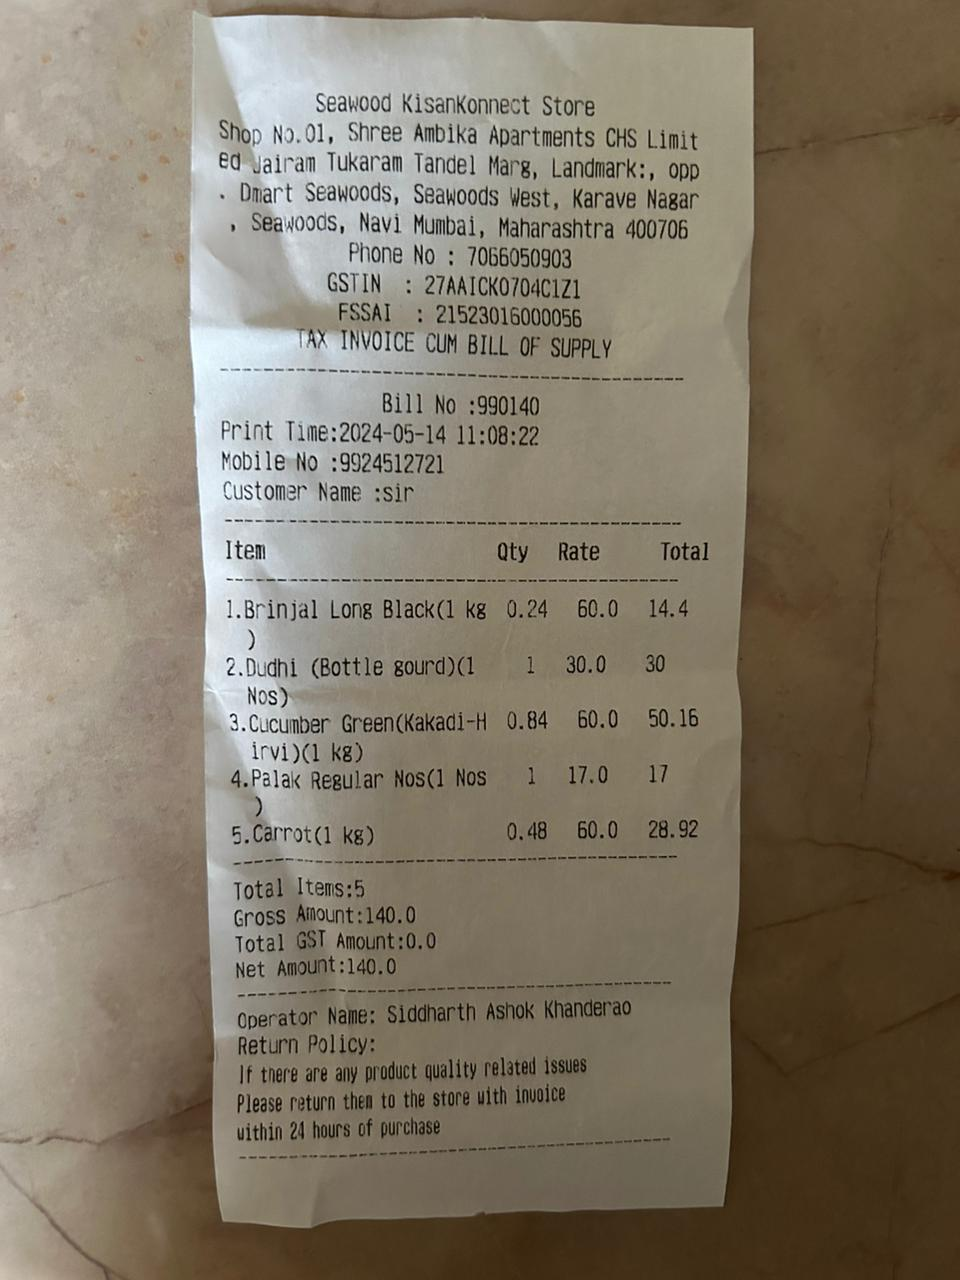

In [ ]:
from PIL import Image
img = Image.open('/content/WhatsApp Image 2024-05-26 at 5.03.17 PM (1).jpeg')
img

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 7s (682 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debcon

In [ ]:
import pytesseract
extracted_info = pytesseract.image_to_string(Image.open('/content/WhatsApp Image 2024-05-26 at 5.03.17 PM (1).jpeg'))
# print(extracted_info)

extracted_info

'   \n  \n \n \n  \n   \n  \n  \n   \n   \n     \n  \n \n \n \n   \n  \n\nSeawood Kisankonnest Store\nShop No.01, Shree Ambika Apartments CHS Limit\nEd vairam Tukaram Tandel Marg, Landmark:, opp\n- Dnart Seawoods, Seawoods West, Karave Nagar\n» Seayoods, Navi Mumbai, Maharashtra 400706\nPhone No ; 7066050903\nGSTIN + 2TARICKO7OACIZL\nFSSAT : 21523016000056\nTAX TNVOICE CUM BILL OF SUPPLY\nBill No :990140\nPrint Tlme:2024-05-14 11:08:22\nMobi le»No :9924512721\nCustomer Name :sir\nItem aty Rate Total\n1.Brinjal Long Black( kg 0.24 60.0 14.4\n)\n2.Dudhi (Bottle gourd) 1 30.0 30\nNos)\n4.Cucunber Green(Kakadi-H 0.84 60.0 50.16\nirvi)(L kg) i\n4,Palak Regular jeans PEO Tg\n)\n\n5. Carrot kg)\n\nTotal Item:\n\n \n    \n\x0c'

In [ ]:
input = extracted_info.split()

In [ ]:
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForTokenClassification.from_pretrained("/content/model/")

# Single prediction
nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="first")
single_test_text = input
result = nlp(single_test_text)
print(result)

[[{'entity_group': 'PHONE', 'score': 0.09617207, 'word': 'Seawood', 'start': 0, 'end': 7}], [{'entity_group': 'PHONE', 'score': 0.09973284, 'word': 'Kisankonnest', 'start': 0, 'end': 12}], [{'entity_group': 'STORE_NAME', 'score': 0.099080026, 'word': 'Store', 'start': 0, 'end': 5}], [{'entity_group': 'STORE_NAME', 'score': 0.09617995, 'word': 'Shop', 'start': 0, 'end': 4}], [{'entity_group': 'STORE_NAME', 'score': 0.10284725, 'word': 'No. 01,', 'start': 0, 'end': 6}], [{'entity_group': 'STORE_NAME', 'score': 0.098975495, 'word': 'Shree', 'start': 0, 'end': 5}], [{'entity_group': 'STORE_NAME', 'score': 0.09838507, 'word': 'Ambika', 'start': 0, 'end': 6}], [{'entity_group': 'STORE_NAME', 'score': 0.0963302, 'word': 'Apartments', 'start': 0, 'end': 10}], [{'entity_group': 'PHONE', 'score': 0.10206392, 'word': 'CHS', 'start': 0, 'end': 3}], [{'entity_group': 'STORE_NAME', 'score': 0.09900811, 'word': 'Limit', 'start': 0, 'end': 5}], [{'entity_group': 'STORE_NAME', 'score': 0.10015172, 'wor

#small inference

In [ ]:
nlp(['kissanconnect','8828330196','seawoods'])

[[{'entity_group': 'STORE_NAME',
   'score': 0.10179491,
   'word': 'kissanconnect',
   'start': 0,
   'end': 13}],
 [{'entity_group': 'PHONE',
   'score': 0.10063749,
   'word': '8828330196',
   'start': 0,
   'end': 10}],
 [{'entity_group': 'STORE_NAME',
   'score': 0.09715812,
   'word': 'seawoods',
   'start': 0,
   'end': 8}]]

In [ ]:
for i in result:
  data = i[0]
  print(data)


{'entity_group': 'PHONE', 'score': 0.09617207, 'word': 'Seawood', 'start': 0, 'end': 7}
{'entity_group': 'PHONE', 'score': 0.09973284, 'word': 'Kisankonnest', 'start': 0, 'end': 12}
{'entity_group': 'STORE_NAME', 'score': 0.099080026, 'word': 'Store', 'start': 0, 'end': 5}
{'entity_group': 'STORE_NAME', 'score': 0.09617995, 'word': 'Shop', 'start': 0, 'end': 4}
{'entity_group': 'STORE_NAME', 'score': 0.10284725, 'word': 'No. 01,', 'start': 0, 'end': 6}
{'entity_group': 'STORE_NAME', 'score': 0.098975495, 'word': 'Shree', 'start': 0, 'end': 5}
{'entity_group': 'STORE_NAME', 'score': 0.09838507, 'word': 'Ambika', 'start': 0, 'end': 6}
{'entity_group': 'STORE_NAME', 'score': 0.0963302, 'word': 'Apartments', 'start': 0, 'end': 10}
{'entity_group': 'PHONE', 'score': 0.10206392, 'word': 'CHS', 'start': 0, 'end': 3}
{'entity_group': 'STORE_NAME', 'score': 0.09900811, 'word': 'Limit', 'start': 0, 'end': 5}
{'entity_group': 'STORE_NAME', 'score': 0.10015172, 'word': 'Ed', 'start': 0, 'end': 2}


In [ ]:
final = {}
for i in result:
  data = i[0]

  key = data.get('entity_group')
  value = data.get('word')

  if key in final:
    if isinstance(final[key],list):
      final[key].append(value)
    else:
      final[key] = [final[key],value]
  else:
    final[key] = value



In [ ]:
final

{'PHONE': ['Seawood',
  'Kisankonnest',
  'CHS',
  'Tukaram',
  'Seayoods',
  '7066050903',
  'GSTIN',
  '2TARICKO7OACIZL',
  'TAX',
  'TNVOICE',
  'CUM',
  'BILL',
  'SUPPLY',
  'Tlme',
  '1',
  '4',
  'Green'],
 'STORE_NAME': ['Store',
  'Shop',
  'No. 01,',
  'Shree',
  'Ambika',
  'Apartments',
  'Limit',
  'Ed',
  'vairam',
  'Marg,',
  'Landmark :,',
  'opp',
  '-',
  'Dnart',
  'Seawoods,',
  'Seawoods',
  'West,',
  'Karave',
  'Nagar',
  '»',
  'Navi',
  'Mumbai,',
  'Maharashtra',
  '400706',
  'Phone',
  'No',
  ';',
  '+',
  'FSSAT',
  '21523016000056',
  'OF',
  'Bill',
  'No',
  ':',
  'Print',
  '11 : 08 : 22',
  'Mobi',
  'le » No',
  ':',
  'Customer',
  'Name',
  ': sir',
  'Item',
  'Rate',
  'Total',
  'Long',
  'Black (',
  'kg',
  '0. 24',
  '60. 0',
  '14. 4',
  ')',
  '2.',
  'gourd )',
  '1',
  '30. 0',
  '30',
  'Nos )',
  '0. 84',
  '60. 0',
  '50. 16',
  'irvi ) ( L',
  'kg )',
  'i',
  '4, Palak',
  'Regular',
  'jeans',
  'Tg',
  ')',
  '5.',
  'Carrot',
 

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
import shutil
source = '/content/models_2345'
output = '/content/models_2345.zip'
shutil.make_archive(output.replace('.zip',''),'zip',source)

'/content/models_2345.zip'

In [ ]:
shutil.copy('/content/models_2345.zip','/content/mydrive/MyDrive')

'/content/mydrive/MyDrive/models_2345.zip'